<a href="https://colab.research.google.com/github/alfonharyos/dts_porto/blob/main/lstm_class_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

from tensorflow.keras.models import load_model

In [ ]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [ ]:
df_train['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

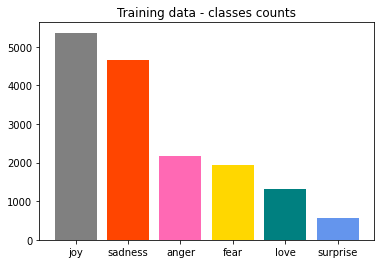

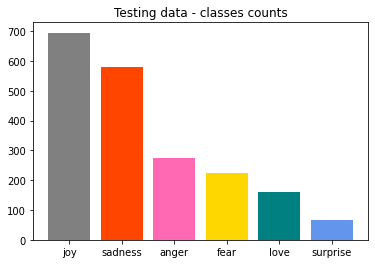

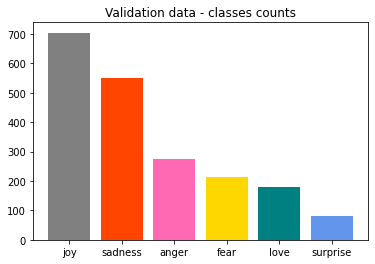

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

height_train = y_train.value_counts().tolist()
bars_train = pd.DataFrame(y_train.value_counts()).index.tolist()
plt.bar(bars_train, height_train, color=colors)
plt.title("Training data - classes counts")
plt.show()

height_test = y_test.value_counts().tolist()
bars_test = pd.DataFrame(y_val.value_counts()).index.tolist()
plt.bar(bars_test, height_test, color=colors)
plt.title("Testing data - classes counts")
plt.show()

height_val = y_val.value_counts().tolist()
bars_val = pd.DataFrame(y_test.value_counts()).index.tolist()
plt.bar(bars_val, height_val, color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
from keras.utils.np_utils import to_categorical
le = LabelEncoder()

y_train_le = le.fit_transform(y_train)
y_test_le  = le.fit_transform(y_test)
y_val_le  = le.fit_transform(y_val)

y_train_cat  = to_categorical(y_train_le)
y_test_cat  = to_categorical(y_test_le)
y_val_cat  = to_categorical(y_val_le)

list(le.classes_)

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
# Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [ ]:
# metrics f1-score
from keras import backend as K

def f1 (y_true, y_pred):
  def recall(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def precision(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build neural network architecture
def model_lstm(unit_1,unit_2,unit_3,unit_4,dropout_rate=0.4):
  model = Sequential()
  model.add(Embedding(num_tokens, embedding_dim, input_length=256))
  model.add(Bidirectional(LSTM(unit_1, dropout=dropout_rate, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, return_sequences=True)))
  model.add(Bidirectional(LSTM(unit_2, dropout=dropout_rate, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True, return_sequences=True)))
  model.add(Bidirectional(LSTM(unit_3, dropout=dropout_rate, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True)))
  model.add(Dense(unit_4, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(6, activation='sigmoid'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy',f1])
  return model

In [ ]:
from sklearn.model_selection import ParameterSampler

units = [64, 128, 256]

param_grid = dict(unit_1=units, 
                  unit_2=units, 
                  unit_3=units, 
                  unit_4=units, 
                  )

rng = np.random.RandomState(0)
param_list = list(ParameterSampler(param_grid, n_iter=5, 
                                   random_state=rng))

In [ ]:
def run_grid():  
  df_all_grid = pd.DataFrame()
  best_score = 0
  i=1
  for g in param_list:
    print('------------------------------------------------------------------')
    print('Iter - '+str(i))
    print(g)
    model = model_lstm(**g)
    history = model.fit(X_train, y_train_cat, 
                        validation_data=(X_val, y_val_cat), 
                        batch_size=32,
                        epochs=5,
                        verbose=1)
    
    # save all metric results (list)
    dict = {'Param':g, 'history':history.history}
    df_all_grid = df_all_grid.append(dict, ignore_index = True)

    # save best score
    new_score = max(history.history['val_f1'])
    if new_score > best_score:
        model.save('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/emotion_model.h5')
        best_score = new_score
        best_grid = [i]+[g]
    i+=1
  print ('-------------------------------------------------------')
  print ("f1_score: %0.5f" % best_score) 
  print ("Grid:", best_grid)
  return best_grid, df_all_grid

In [ ]:
gs = run_grid()

------------------------------------------------------------------
Iter - 1
{'unit_4': 128, 'unit_3': 128, 'unit_2': 256, 'unit_1': 64}
Epoch 1/5
500/500 [==============================] - 52s 87ms/step - loss: 1.0745 - accuracy: 0.5931 - f1: 0.4826 - val_loss: 0.5099 - val_accuracy: 0.8200 - val_f1: 0.5854
Epoch 2/5
500/500 [==============================] - 42s 84ms/step - loss: 0.3391 - accuracy: 0.8891 - f1: 0.6421 - val_loss: 0.2246 - val_accuracy: 0.9190 - val_f1: 0.6935
Epoch 3/5
500/500 [==============================] - 41s 83ms/step - loss: 0.1735 - accuracy: 0.9404 - f1: 0.7330 - val_loss: 0.2078 - val_accuracy: 0.9230 - val_f1: 0.7582
Epoch 4/5
500/500 [==============================] - 42s 85ms/step - loss: 0.1228 - accuracy: 0.9559 - f1: 0.7536 - val_loss: 0.1951 - val_accuracy: 0.9245 - val_f1: 0.7779
Epoch 5/5
500/500 [==============================] - 41s 83ms/step - loss: 0.0942 - accuracy: 0.9644 - f1: 0.7828 - val_loss: 0.2029 - val_accuracy: 0.9325 - val_f1: 0.8269

In [ ]:
result_grid = gs[1]
result_grid

,Param,history
0,"{'unit_4': 128, 'unit_3': 128, 'unit_2': 256, ...","{'loss': [1.074530005455017, 0.339083254337310..."
1,"{'unit_4': 64, 'unit_3': 64, 'unit_2': 64, 'un...","{'loss': [1.1578845977783203, 0.35875457525253..."
2,"{'unit_4': 128, 'unit_3': 256, 'unit_2': 64, '...","{'loss': [1.017234444618225, 0.266397207975387..."
3,"{'unit_4': 128, 'unit_3': 128, 'unit_2': 128, ...","{'loss': [1.121776819229126, 0.386341214179992..."
4,"{'unit_4': 256, 'unit_3': 256, 'unit_2': 128, ...","{'loss': [1.102744460105896, 0.318675607442855..."


In [ ]:
best_param = gs[0]
best_param

[5, {'unit_1': 256, 'unit_2': 128, 'unit_3': 256, 'unit_4': 256}]

## Run Model with Best Param

In [ ]:
best_model = load_model('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/emotion_model.h5', custom_objects={'f1':f1}, compile=False)

In [ ]:
#Callback
callback = EarlyStopping(
    min_delta=0.01, 
    mode='max', 
    monitor='val_f1', 
    patience=7, 
    restore_best_weights=True
)

In [ ]:
# compile
best_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy',f1])

# Fit model
history = best_model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    verbose=1,
                    callbacks=callback
                    )
                    

Epoch 1/50
500/500 [==============================] - 62s 108ms/step - loss: 0.0884 - accuracy: 0.9668 - f1: 0.9230 - val_loss: 0.1708 - val_accuracy: 0.9355 - val_f1: 0.9031
Epoch 2/50
500/500 [==============================] - 51s 102ms/step - loss: 0.0600 - accuracy: 0.9782 - f1: 0.9360 - val_loss: 0.1913 - val_accuracy: 0.9350 - val_f1: 0.9045
Epoch 3/50
500/500 [==============================] - 52s 104ms/step - loss: 0.0489 - accuracy: 0.9816 - f1: 0.9534 - val_loss: 0.2153 - val_accuracy: 0.9350 - val_f1: 0.9293
Epoch 4/50
500/500 [==============================] - 51s 102ms/step - loss: 0.0440 - accuracy: 0.9837 - f1: 0.9623 - val_loss: 0.2549 - val_accuracy: 0.9360 - val_f1: 0.9330
Epoch 5/50
500/500 [==============================] - 51s 102ms/step - loss: 0.0364 - accuracy: 0.9871 - f1: 0.9723 - val_loss: 0.3050 - val_accuracy: 0.9315 - val_f1: 0.9260
Epoch 6/50
500/500 [==============================] - 51s 103ms/step - loss: 0.0350 - accuracy: 0.9879 - f1: 0.9776 - val_los

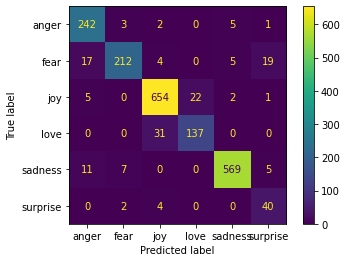

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y_pred = le.inverse_transform(np.argmax(best_model.predict(X_test), axis=-1))
cm = confusion_matrix(y_pred, y_test, 
                                 labels=list(le.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(le.classes_))
disp.plot()
plt.show()

In [ ]:
best_model_before = load_model('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/emotion_model.h5', custom_objects={'f1':f1}, compile=False)
best_model_before.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy',f1])
best_model_before.evaluate(X_test, y_test_cat, verbose=1)

63/63 [==============================] - 6s 39ms/step - loss: 0.2063 - accuracy: 0.9200 - f1: 0.8722


[0.2063012421131134, 0.9200000166893005, 0.8722041249275208]

In [ ]:
best_model.evaluate(X_test, y_test_cat, verbose=1)

63/63 [==============================] - 2s 38ms/step - loss: 0.2480 - accuracy: 0.9270 - f1: 0.9240


[0.248041570186615, 0.9269999861717224, 0.9240471720695496]

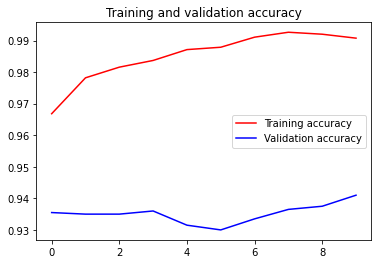

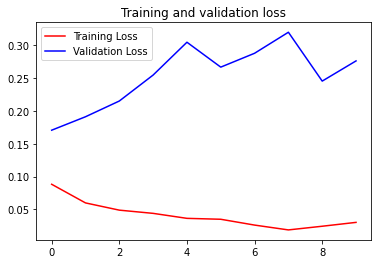

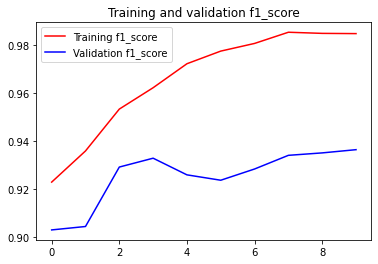

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score = history.history['f1']
val_f1_score = history.history['val_f1']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, f1_score, 'r', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label='Validation f1_score')
plt.title('Training and validation f1_score')
plt.legend()
plt.figure()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "the food is delicious"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(best_model.predict(sentence), axis=-1))[0]
    proba =  np.max(best_model.predict(sentence))
    print(f"{result} : {proba}\n")

the food is delicious
joy : 0.999147355556488



In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
best_model.save('/content/drive/MyDrive/DTS/Proa_ML_tensor/Assignment_nlp/Emotion_Recognition.h5')